In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import numpy as np
import math
import skimage
from skimage import data,io
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

import matplotlib
import matplotlib.pyplot as plt

In [45]:
def get_DoGs(image, num_octaves, s, k):
  DoGs = []
  sigma = 1.6
  k_pow = 0
  img1 = skimage.color.rgb2gray(image)
  # print('num_octaves={}'.format(num_octaves))
  for i in range(num_octaves):
    # print('i={}'.format(i))
    DoG_current_octave = []
    prev_gaussian = None
    for j in range(s+1):
      curr_sigma = math.pow(k, j)*sigma
      curr_gaussian = skimage.filters.gaussian(image, curr_sigma)
      if(j != 0):
        DoG_current_octave.append(curr_gaussian - prev_gaussian)
      prev_gaussian = curr_gaussian
    sigma*=2
    print(len(DoG_current_octave))
    DoGs.append(DoG_current_octave)

  return DoGs

In [46]:
def get_extrema_points(DoGs, num_octaves, image, s):
  l = image.shape[0]
  b = image.shape[1]

  extrema_points = np.zeros((l,b))

  for i in range(num_octaves):
    for j in range(1,s-1):
      # print(i,j)
      for r in range(1,l-1):
        for c in range(1, b-1):
          # if(i==1 and j==1):
            # print(r,c)
          curr_val = DoGs[i][j][r][c]
          curr_scale_8 = DoGs[i][j][r-1:r+2, c-1:c+2]
          curr_scale_8[1][1]-=1
          prev_scale_9 = DoGs[i][j-1][r-1:r+2, c-1:c+2]
          next_scale_9 = DoGs[i][j+1][r-1:r+2, c-1:c+2]

          curr8  = curr_scale_8 >= curr_val
          prev9 = prev_scale_9 >= curr_val
          next9 = next_scale_9 >= curr_val

          extrema_flag = np.sum(curr8) + np.sum(prev9) + np.sum(next9)
          # print(extrema_flag)

          if extrema_flag == 0:  # in case of maxima
                  extrema_points[r, c] = 1

          curr_scale_8[1][1]+=2

          curr8  = curr_scale_8 <= curr_val
          prev9 = prev_scale_9 <= curr_val
          next9 = next_scale_9 <= curr_val

          extrema_flag = np.sum(curr8) + np.sum(prev9) + np.sum(next9)

          if extrema_flag == 0:  # in case of minima
                  extrema_points[r, c] = 1

  sum1 = list(map(sum, extrema_points))
  print('Number of extrema points = {}'.format(sum(sum1)))

  return extrema_points

In [47]:
def SIFT(image): 
  s = 5
  k = math.pow(2, 1/s)
  num_octaves = 1
  DoGs = []
  sigma = 1.6
  k_pow = 0
  image_grayscale = skimage.color.rgb2gray(image)

  DoGs = get_DoGs(image_grayscale, num_octaves, s, k)

  extrema_points = get_extrema_points(DoGs, num_octaves, image_grayscale, s)

  fig, ax = plt.subplots()
  plt.imshow(image_grayscale + extrema_points , cmap="gray")

5


<ipython-input-48-970fc4d61178>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = skimage.color.rgb2gray(img)
<ipython-input-47-2d668ab43459>:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


Number of extrema points = 7494.0


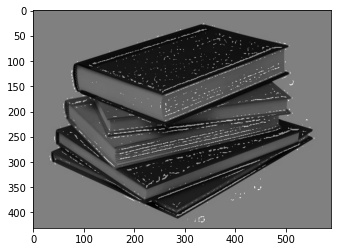

In [48]:
img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment1/AIP2023-Assignment1/assignment1_data/books.png')
img_gray = skimage.color.rgb2gray(img)
SIFT(img)

<ipython-input-47-2d668ab43459>:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 7869.0


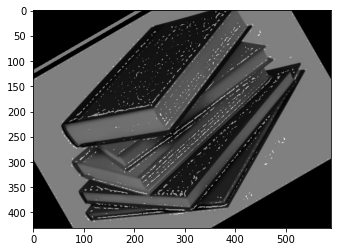

In [49]:
book_image_rotated = skimage.transform.rotate(img, 30)
SIFT(book_image_rotated)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 1876.0


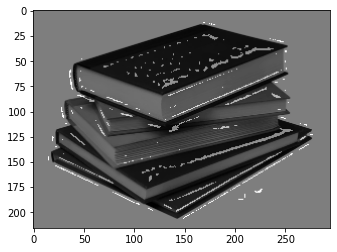

In [50]:
book_image_downscaled = skimage.transform.rescale(img_gray, 0.5, anti_aliasing=False)
SIFT(book_image_downscaled)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 20602.0


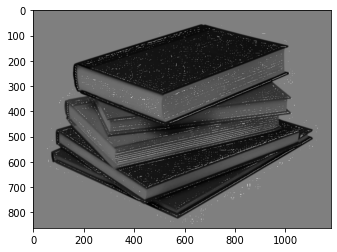

In [51]:
book_image_upscaled = skimage.transform.rescale(img_gray, 2, anti_aliasing=False)
SIFT(book_image_upscaled)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 3054.0


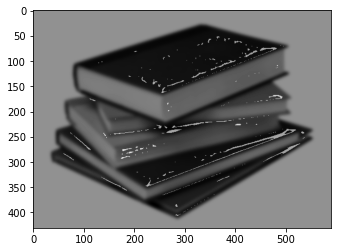

In [52]:
book_image_blurred = skimage.filters.gaussian(img_gray, 3)
SIFT(book_image_blurred)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 13835.0


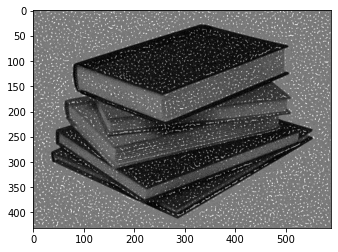

In [53]:
book_image_noisy = skimage.util.random_noise(img_gray, mode='gaussian')
SIFT(book_image_noisy)

<ipython-input-54-ce794c19757c>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img1_gray = skimage.color.rgb2gray(img1)
<ipython-input-47-2d668ab43459>:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 48072.0


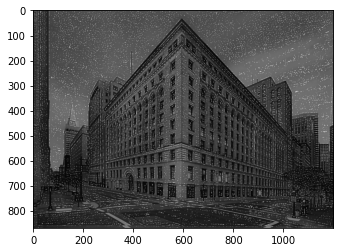

In [54]:
img1 = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment1/AIP2023-Assignment1/assignment1_data/building.png')
img1_gray = skimage.color.rgb2gray(img1)
SIFT(img1)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 41023.0


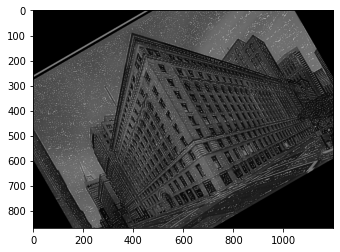

In [55]:
building_image_rotated = skimage.transform.rotate(img1_gray, 30)
SIFT(building_image_rotated)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 11307.0


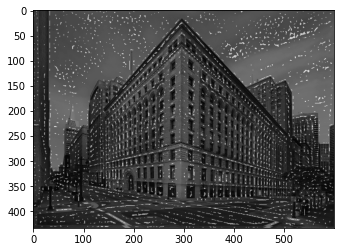

In [56]:
building_image_downscaled = skimage.transform.rescale(img1_gray, 0.5, anti_aliasing=False)
SIFT(building_image_downscaled)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 156643.0


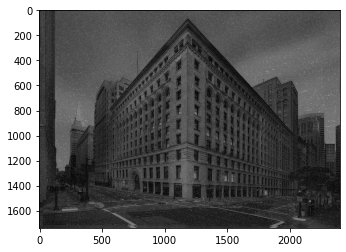

In [57]:
building_image_upscaled = skimage.transform.rescale(img1_gray, 2, anti_aliasing=False)
SIFT(building_image_upscaled)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 15414.0


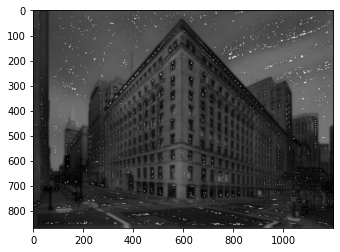

In [58]:
building_image_blurred = skimage.filters.gaussian(img1_gray, 3)
SIFT(building_image_blurred)

<ipython-input-47-2d668ab43459>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_grayscale = skimage.color.rgb2gray(image)
<ipython-input-45-d6ae06a6e504>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img1 = skimage.color.rgb2gray(image)


5
Number of extrema points = 55654.0


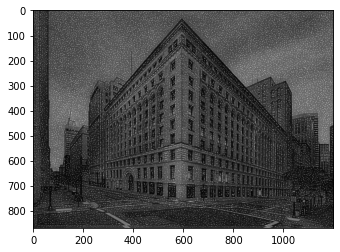

In [59]:
building_image_noisy = skimage.util.random_noise(img1_gray, mode='gaussian')
SIFT(building_image_noisy)

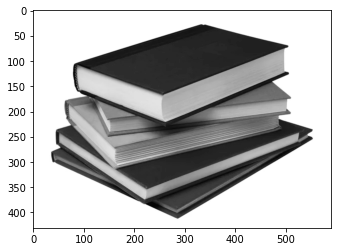

In [60]:
plt.imshow(img_gray, cmap="gray")

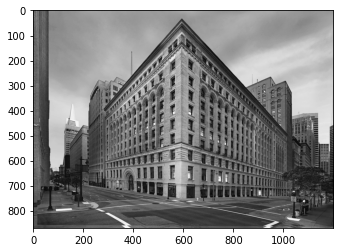

In [61]:
plt.imshow(img1_gray, cmap="gray")